<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Data Analytics 

### Ensemble Declustering for Spatial Data Debiasing in Python  


#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

### Wide Array Declustering Data Distribution Representativity Plotting in Python with GeostatsPy

Here's a simple workflow with some basic univariate statistics and distribution representativity. This should help you get started data declustering to address spatial sampling bias.

#### Geostatistical Sampling Representativity

In general, we should assume that all spatial data that we work with is biased.

##### Source of Spatial Sampling Bias

Data is collected to answer questions:
* how far does the contaminant plume extend? – sample peripheries
* where is the fault? – drill based on seismic interpretation
* what is the highest mineral grade? – sample the best part
* who far does the reservoir extend? – offset drilling
and to maximize NPV directly:
* maximize production rates

**Random Sampling**: when every item in the population has a equal chance of being chosen. Selection of every item is independent of every other selection.
Is random sampling sufficient for subsurface?  Is it available?
* it is not usually available, would not be economic
* data is collected answer questions
    * how large is the reservoir, what is the thickest part of the reservoir 
* and wells are located to maximize future production
    * dual purpose appraisal and injection / production wells!

**Regular Sampling**: when samples are taken at regular intervals (equally spaced).  
* less reliable than random sampling.
* Warning: may resonate with some unsuspected environmental variable.

What do we have?
* we usually have biased, opportunity sampling 
* we must account for bias (debiasing will be discussed later)

So if we were designing sampling for representativity of the sample set and resulting sample statistics, by theory we have 2 options, random sampling and regular sampling.

* What would happen if you proposed random sampling in the Gulf of Mexico at $150M per well?

We should not change current sampling methods as they result in best economics, we should address sampling bias in the data.

Never use raw spatial data without access sampling bias / correcting.

##### Mitigating Sampling Bias

In this demonstration we will take a biased spatial sample data set and apply declustering using **GeostatsPy** functionality.

#### Objective 

In the PGE 383: Stochastic Subsurface Modeling class I want to provide hands-on experience with building subsurface modeling workflows. Python provides an excellent vehicle to accomplish this. I have coded a package called GeostatsPy with GSLIB: Geostatistical Library (Deutsch and Journel, 1998) functionality that provides basic building blocks for building subsurface modeling workflows. 

The objective is to remove the hurdles of subsurface modeling workflow construction by providing building blocks and sufficient examples. This is not a coding class per se, but we need the ability to 'script' workflows working with numerical methods.    

#### Getting Started

Here's the steps to get setup in Python with the GeostatsPy package:

1. Install Anaconda 3 on your machine (https://www.anaconda.com/download/). 
2. From Anaconda Navigator (within Anaconda3 group), go to the environment tab, click on base (root) green arrow and open a terminal. 
3. In the terminal type: pip install geostatspy. 
4. Open Jupyter and in the top block get started by copy and pasting the code block below from this Jupyter Notebook to start using the geostatspy functionality. 

You will need to copy the data file to your working directory.  They are available here:

* Tabular data - sample_data_biased.csv at https://git.io/fh0CW

There are exampled below with these functions. You can go here to see a list of the available functions, https://git.io/fh4eX, other example workflows and source code. 

In [1]:
import geostatspy.GSLIB as GSLIB          # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats    # GSLIB methods convert to Python        

We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import numpy as np                        # ndarrys for gridded data
import pandas as pd                       # DataFrames for tabular data
import os                                 # set working directory, run executables
import matplotlib.pyplot as plt           # for plotting
from scipy import stats                   # summary statistics
from numba import jit                     # code precompile for acceleration 
import random                             # bootstrap

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [3]:
os.chdir("c:/PGE383")             # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object.  

In [4]:
df = pd.read_csv('sample_data_biased.csv')     # load our data table (wrong name!)

No error now! It worked, we loaded our file into our DataFrame called 'df'. But how do you really know that it worked? Visualizing the DataFrame would be useful and we already leard about these methods in this demo (https://git.io/fNgRW). 

We can preview the DataFrame by printing a slice or by utilizing the 'head' DataFrame member function (with a nice and clean format, see below). With the slice we could look at any subset of the data table and with the head command, add parameter 'n=13' to see the first 13 rows of the dataset.  

In [5]:
#print(df.iloc[0:5,:])                   # display first 4 samples in the table as a preview
df.head(n=13)                           # we could also use this command for a table preview

,X,Y,Facies,Porosity,Perm
0,100,900,1,0.115359,5.736104
1,100,800,1,0.136425,17.211462
2,100,600,1,0.135810,43.724752
3,100,500,0,0.094414,1.609942
4,100,100,0,0.113049,10.886001
5,200,800,1,0.154648,106.491795
6,200,700,1,0.153113,140.976324
7,200,500,1,0.126167,12.548074
8,200,400,0,0.094750,1.208561
9,200,100,1,0.150961,44.687430


#### Summary Statistics for Tabular Data

The table includes X and Y coordinates (meters), Facies 1 and 2 (1 is sandstone and 0 interbedded sand and mudstone), Porosity (fraction), and permeability as Perm (mDarcy). 

There are a lot of efficient methods to calculate summary statistics from tabular data in DataFrames. The describe command provides count, mean, minimum, maximum, and quartiles all in a nice data table. We use transpose just to flip the table so that features are on the rows and the statistics are on the columns.

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,289.0,475.813149,254.277530,0.000000,300.000000,430.000000,670.000000,990.000000
Y,289.0,529.692042,300.895374,9.000000,269.000000,549.000000,819.000000,999.000000
Facies,289.0,0.813149,0.390468,0.000000,1.000000,1.000000,1.000000,1.000000
Porosity,289.0,0.134744,0.037745,0.058548,0.106318,0.126167,0.154220,0.228790
Perm,289.0,207.832368,559.359350,0.075819,3.634086,14.908970,71.454424,5308.842566


Let's store metrics to compare each of the methods.

* diagnostics to explore the spatial sampling bias in the dataset 

In [7]:
methods = ['Cell', 'Kriging', 'Poly']
por_dmean = np.zeros(3)
wts_mean = np.zeros(3)
wts_std = np.zeros(3)

#### Specify the Area of Interest

It is natural to set the x and y coordinate and feature ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? Also, let's pick a color map for display. I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). We will assume a study area of 0 to 1,000m in x and y and omit any data outside this area.

In [8]:
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
pormin = 0.05; pormax = 0.26;             # range of porosity values
cmap = plt.cm.inferno                    # color map

Visualizing Tabular Data with Location Maps¶ 
Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Now we can populate the plotting parameters and visualize the porosity data.

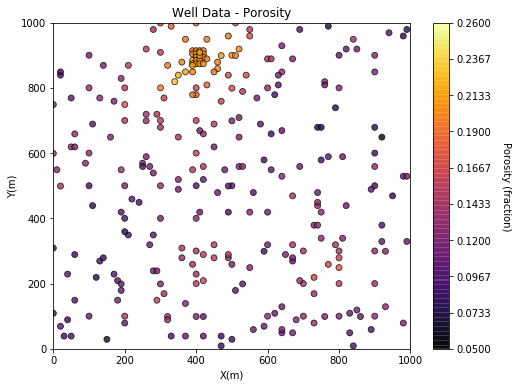

In [10]:
GSLIB.locmap(df,'X','Y','Porosity',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap,'locmap_Porosity')

Look carefully, and you'll notice the the spatial samples are more dense in the high porosity regions and lower in the low porosity regions.  There is preferential sampling.  We cannot use the naive statistics to represent this region.  We have to correct for the clustering of the samples in the high porosity regions. 

### Cell-based Declustering

Let's try cell declustering. We can interpret that we will want to minimize the declustering mean and that a cell size of between 100 - 200m is likely a good cell size, this is 'an ocular' estimate of the largest average spacing in the sparsely sampled regions.   

Let's check out the declus program reimplimented from GSLIB.

In [11]:
geostats.declus

<function geostatspy.geostats.declus(df, xcol, ycol, vcol, iminmax, noff, ncell, cmin, cmax)>

We can now populate the parameters. We will run a very wide range of cell sizes, from 10m to 2,000m ('cmin' and 'cmax') and take the cell size that minimizes the declustered mean ('iminmax' = 1 minimize, and = 0 maximize). Multiple offsets (number of these is 'noff') uses multiple grid origins and averages the results to remove sensitivity to grid position.  The ncell is the number of cell sizes.

The output from this program is:

* wts - an array with the weigths for each data (they sum to the number of data, 1 indicates nominal weight)
* cell_sizes - an array with the considered cell sizes
* dmeans - de an 

In [12]:
wts, cell_sizes, dmeans = geostats.declus(df,'X','Y','Porosity',iminmax = 1, noff= 10, ncell=100,cmin=10,cmax=2000)
df['Wts'] = wts                            # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

There are 289 data with:
   mean of      0.13474387540138408 
   min and max  0.058547873 and 0.228790002
   standard dev 0.03767982164385207 


,X,Y,Facies,Porosity,Perm,Wts
0,100,900,1,0.115359,5.736104,3.064286
1,100,800,1,0.136425,17.211462,1.076608
2,100,600,1,0.135810,43.724752,0.997239
3,100,500,0,0.094414,1.609942,1.165119
4,100,100,0,0.113049,10.886001,1.224164


Let's look at the location map of the weights.

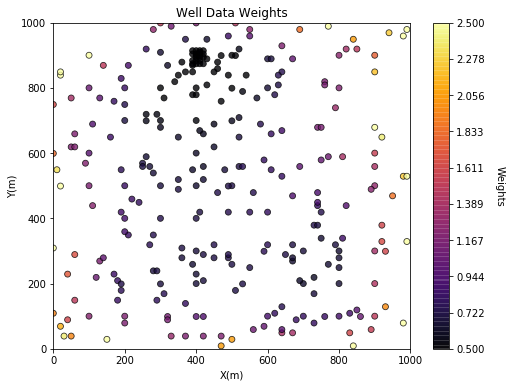

In [13]:
GSLIB.locmap(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.5,2.5,'Well Data Weights','X(m)','Y(m)','Weights',cmap,'locmap_Weights')

Does it look correct?  See the weight varies with local sampling density?  

Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135.
Porosity declustered mean is 0.121.
Correction of 0.1002.

Summary statistics of the declsutering weights:
DescribeResult(nobs=289, minmax=(0.2819756671865989, 3.984325446814365), mean=0.9999999999999996, variance=0.40927076480664726, skewness=1.9395015754905447, kurtosis=4.287460624778004)


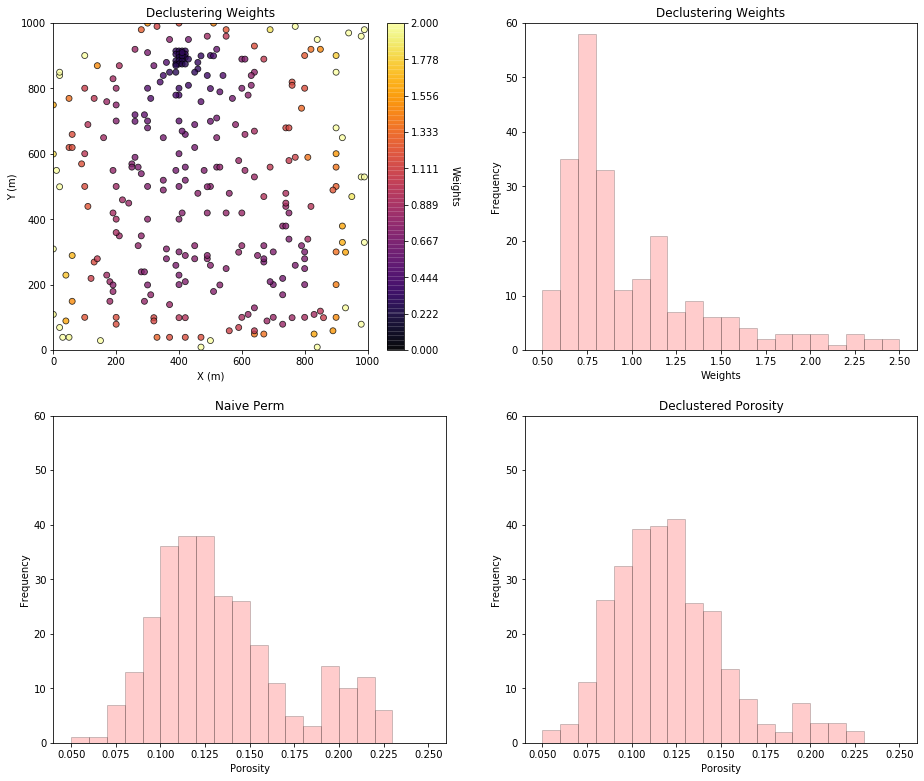

In [14]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,2.0,'Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(222)
GSLIB.hist_st(df['Wts'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Weights",title="Declustering Weights")
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Perm")
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts'],xlabel="Porosity",title="Declustered Porosity")
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean[0] = np.average(df['Porosity'].values,weights=df['Wts'].values)

wts_mean[0] = np.average(df['Wts'].values)
wts_std[0] = np.std(df['Wts'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean[0],3))+'.')
cor = (por_mean-por_dmean[0])/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declsutering weights:')
print(stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

Now let's look at the plot of the declustered porosity mean vs. the declustering cell size over the 100 runs. At very small and very large cell size the declustered mean is the naive mean. 

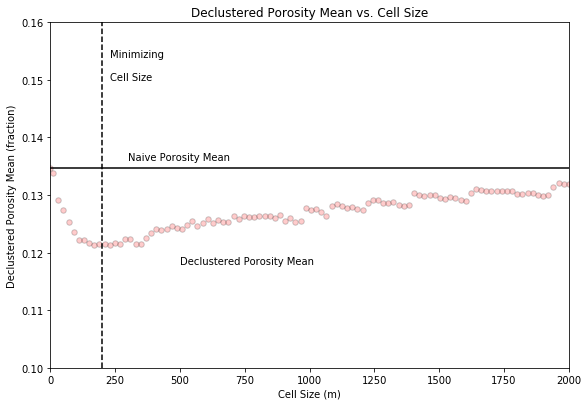

In [15]:
plt.subplot(111)
plt.scatter(cell_sizes,dmeans, s=30, alpha = 0.2, edgecolors = "black", facecolors = 'red')
plt.xlabel('Cell Size (m)')
plt.ylabel('Declustered Porosity Mean (fraction)')
plt.title('Declustered Porosity Mean vs. Cell Size')
plt.plot([0,2000],[por_mean,por_mean],color = 'black')
plt.plot([200,200],[0.10,0.16],color = 'black',linestyle='dashed')
plt.text(300., 0.136, r'Naive Porosity Mean')
plt.text(500., 0.118, r'Declustered Porosity Mean')
plt.text(230., 0.154, r'Minimizing')
plt.text(230., 0.150, r'Cell Size')
plt.ylim(0.10,0.16)
plt.xlim(0,2000)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.2, top=1.2, wspace=0.2, hspace=0.2)
plt.show()

The cell size that minimizes the declustered mean is about 200m (estimated from the figure). This makes sense given our previous observation of the data spacing. 

### Kriging-based Declustering

Let's take the standard 2D kriging method and modify it

* we will sum the weights assigned to each spatial data

* calculate the weights as the normalized sum of the weights

In [16]:
def declus_kriging(
    df,
    xcol,
    ycol,
    vcol,
    tmin,
    tmax,
    nx,
    xmn,
    xsiz,
    ny,
    ymn,
    ysiz,
    nxdis,
    nydis,
    ndmin,
    ndmax,
    radius,
    ktype,
    skmean,
    vario,
):
    """GSLIB's KB2D program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :param nxdis: number of discretization points for a block
    :param nydis: number of discretization points for a block
    :param ndmin: minimum number of data points to use for kriging a block
    :param ndmax: maximum number of data points to use for kriging a block
    :param radius: maximum isotropic search radius
    :param ktype:
    :param skmean:
    :param vario:
    :return:
    """
    
# Constants
    UNEST = -999.
    EPSLON = 1.0e-10
    VERSION = 2.907
    first = True
    PMX = 9999.0    
    MAXSAM = ndmax + 1
    MAXDIS = nxdis * nydis
    MAXKD = MAXSAM + 1
    MAXKRG = MAXKD * MAXKD
    
# load the variogram
    nst = vario['nst']
    cc = np.zeros(nst); aa = np.zeros(nst); it = np.zeros(nst)
    ang = np.zeros(nst); anis = np.zeros(nst)
    
    c0 = vario['nug']; 
    cc[0] = vario['cc1']; it[0] = vario['it1']; ang[0] = vario['azi1']; 
    aa[0] = vario['hmaj1']; anis[0] = vario['hmin1']/vario['hmaj1'];
    if nst == 2:
        cc[1] = vario['cc2']; it[1] = vario['it2']; ang[1] = vario['azi2']; 
        aa[1] = vario['hmaj2']; anis[1] = vario['hmin2']/vario['hmaj2'];
    
# Allocate the needed memory:   
    xdb = np.zeros(MAXDIS)
    ydb = np.zeros(MAXDIS)
    xa = np.zeros(MAXSAM)
    ya = np.zeros(MAXSAM)
    vra = np.zeros(MAXSAM)
    dist = np.zeros(MAXSAM)
    nums = np.zeros(MAXSAM)
    r = np.zeros(MAXKD)
    rr = np.zeros(MAXKD)
    s = np.zeros(MAXKD)
    a = np.zeros(MAXKRG)
    kmap = np.zeros((nx,ny))
    vmap = np.zeros((nx,ny))

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    ndmax = min(ndmax,nd)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)

# Summary statistics for the data after trimming
    avg = vr.mean()
    stdev = vr.std()
    ss = stdev**2.0
    vrmin = vr.min()
    vrmax = vr.max()
    
# Track the sum of weights for declustering
    sum_wts = np.zeros(nd)

# Set up the discretization points per block.  Figure out how many
# are needed, the spacing, and fill the xdb and ydb arrays with the
# offsets relative to the block center (this only gets done once):
    ndb  = nxdis * nydis
    if ndb > MAXDIS: 
        print('ERROR KB2D: Too many discretization points ')
        print('            Increase MAXDIS or lower n[xy]dis')
        return kmap
    xdis = xsiz  / max(float(nxdis),1.0)
    ydis = ysiz  / max(float(nydis),1.0)
    xloc = -0.5*(xsiz+xdis)
    i    = -1   # accounting for 0 as lowest index
    for ix in range(0,nxdis):       
        xloc = xloc + xdis
        yloc = -0.5*(ysiz+ydis)
        for iy in range(0,nydis): 
            yloc = yloc + ydis
            i = i+1
            xdb[i] = xloc
            ydb[i] = yloc

# Initialize accumulators:
    cbb  = 0.0
    rad2 = radius*radius

# Calculate Block Covariance. Check for point kriging.
    rotmat, maxcov = geostats.setup_rotmat(c0,nst,it,cc,ang,PMX)
    cov = geostats.cova2(xdb[0],ydb[0],xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
# Keep this value to use for the unbiasedness constraint:
    unbias = cov
    first  = False
    if ndb <= 1:
        cbb = cov
    else:
        for i in range(0,ndb): 
            for j in range(0,ndb): 
                cov = cova2(xdb[i],ydb[i],xdb[j],ydb[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
            if i == j: 
                cov = cov - c0
            cbb = cbb + cov
        cbb = cbb/real(ndb*ndb)

# MAIN LOOP OVER ALL THE BLOCKS IN THE GRID:
    nk = 0
    ak = 0.0
    vk = 0.0
    for iy in range(0,ny):
        yloc = ymn + (iy-0)*ysiz  
        for ix in range(0,nx):
            xloc = xmn + (ix-0)*xsiz
            current_node = (yloc,xloc)
        
# Find the nearest samples within each octant: First initialize
# the counter arrays:
            na = -1   # accounting for 0 as first index
            dist.fill(1.0e+20)
            nums.fill(-1)
            dist, nums = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
            # remove any data outside search radius
            na = len(dist)
            nums = nums[dist<radius]
            dist = dist[dist<radius] 
            na = len(dist)        

# Is there enough samples?
            if na + 1 < ndmin:   # accounting for min index of 0
                est  = UNEST
                estv = UNEST
                print('UNEST at ' + str(ix) + ',' + str(iy))
            else:

# Put coordinates and values of neighborhood samples into xa,ya,vra:
                for ia in range(0,na):
                    jj = int(nums[ia])
                    xa[ia]  = x[jj]
                    ya[ia]  = y[jj]
                    vra[ia] = vr[jj]
                    
# Handle the situation of only one sample:
                if na == 0:  # accounting for min index of 0 - one sample case na = 0
                    cb1 = geostats.cova2(xa[0],ya[0],xa[0],ya[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    xx  = xa[0] - xloc
                    yy  = ya[0] - yloc

# Establish Right Hand Side Covariance:
                    if ndb <= 1:
                        cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                    else:
                        cb  = 0.0
                        for i in range(0,ndb):                  
                            cb = cb + cova2(xx,yy,xdb[i],ydb[i],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                            dx = xx - xdb(i)
                            dy = yy - ydb(i)
                            if (dx*dx+dy*dy) < EPSLON:
                                cb = cb - c0
                            cb = cb / real(ndb)
                    if ktype == 0:
                        s[0] = cb/cbb
                        est  = s[0]*vra[0] + (1.0-s[0])*skmean
                        estv = cbb - s[0] * cb
                    else:
                        est  = vra[0]
                        estv = cbb - 2.0*cb + cb1

# sum the kriging weights
                   # print(nums)
                    #jj = int(nums[0])
                    #sum_wts[jj] = sum_wts[jj] + s[0]   

                        
                else:

# Solve the Kriging System with more than one sample:
                    neq = na + ktype # accounting for first index of 0
#                    print('NEQ' + str(neq))
                    nn  = (neq + 1)*neq/2

# Set up kriging matrices:
                    iin=-1 # accounting for first index of 0
                    for j in range(0,na):

# Establish Left Hand Side Covariance Matrix:
                        for i in range(0,na):  # was j - want full matrix                    
                            iin = iin + 1
                            a[iin] = geostats.cova2(xa[i],ya[i],xa[j],ya[j],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov) 
                        if ktype == 1:
                            iin = iin + 1
                            a[iin] = unbias
                        xx = xa[j] - xloc
                        yy = ya[j] - yloc

# Establish Right Hand Side Covariance:
                        if ndb <= 1:
                            cb = geostats.cova2(xx,yy,xdb[0],ydb[0],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                        else:
                            cb  = 0.0
                            for j1 in range(0,ndb):    
                                cb = cb + cova2(xx,yy,xdb[j1],ydb[j1],nst,c0,PMX,cc,aa,it,ang,anis,rotmat,maxcov)
                                dx = xx - xdb[j1]
                                dy = yy - ydb[j1]
                                if (dx*dx+dy*dy) < EPSLON:
                                    cb = cb - c0
                            cb = cb / real(ndb)
                        r[j]  = cb
                        rr[j] = r[j]

# Set the unbiasedness constraint:
                    if ktype == 1:
                        for i in range(0,na):
                            iin = iin + 1
                            a[iin] = unbias
                        iin      = iin + 1
                        a[iin]   = 0.0
                        r[neq-1]  = unbias
                        rr[neq-1] = r[neq]

# Solve the Kriging System:
#                    print('NDB' + str(ndb))
#                    print('NEQ' + str(neq) + ' Left' + str(a) + ' Right' + str(r))
#                    stop
                    s = geostats.ksol_numpy(neq,a,r)
                    ising = 0 # need to figure this out
#                    print('weights' + str(s))
#                    stop
                
            
# Write a warning if the matrix is singular:
                    if ising != 0:
                        print('WARNING KB2D: singular matrix')
                        print('              for block' + str(ix) + ',' + str(iy)+ ' ')
                        est  = UNEST
                        estv = UNEST
                    else:

# Compute the estimate and the kriging variance:
                        est  = 0.0
                        estv = cbb
                        sumw = 0.0
                        if ktype == 1: 
                            estv = estv - (s[na])*unbias
                        for i in range(0,na):                          
                            sumw = sumw + s[i]
                            est  = est  + s[i]*vra[i]
                            estv = estv - s[i]*rr[i]

# sum the kriging weights
                            jj = int(nums[i])
                            sum_wts[jj] = sum_wts[jj] + s[i]
                            
                        if ktype == 0: 
                            est = est + (1.0-sumw)*skmean
            kmap[ny-iy-1,ix] = est
            vmap[ny-iy-1,ix] = estv
            if est > UNEST:
                nk = nk + 1
                ak = ak + est
                vk = vk + est*est

# END OF MAIN LOOP OVER ALL THE BLOCKS:

    if nk >= 1:
        ak = ak / float(nk)
        vk = vk/float(nk) - ak*ak
        print('  Estimated   ' + str(nk) + ' blocks ')
        print('      average   ' + str(ak) + '  variance  ' + str(vk))

# standardize the kriging weights
    sum_sum_wts = np.sum(sum_wts)
    if sum_sum_wts <= 0.0:
        sum_wts = np.ones(nd)
    else:
        sum_wts = sum_wts/sum_sum_wts*nd
        
    return sum_wts

Let's assume a reasoanble grid for kriging

* sufficient resolution to capture the spatial context of the data

* higher resolution results in more precision in the declustering weights

We will also assume simple kriging parameters.

* we want to limit the search to the range of correlation for computation efficiency

We will also assume a variogram

* very large range will result in equal weights

* no spatial correlation will result in equal weights

In [17]:
# set grid parameters
xmin = 0.0; xmax = 1000.0               # range of x values
ymin = 0.0; ymax = 1000.0               # range of y values
xsiz = 10; ysiz = 10                    # cell size
nx = 100; ny = 100                      # number of cells
xmn = 5; ymn = 5                        # grid origin, location center of lower left cell

# set kriging parameters
nxdis = 1; nydis = 1                       # block kriging discretizations, 1 for point kriging
ndmin = 0; ndmax = 10                      # minimum and maximum data for kriging 
radius = 100                               # maximum search distance
ktype = 0                                  # kriging type, 0 - simple, 1 - ordinary
ivtype = 0                                 # variable type, 0 - categorical, 1 - continuous
tmin = -999; tmax = 999;                   # data trimming limits
skmean = 0.0

# define a variogram model
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0,hmaj1=100,hmin1=100) # porosity sand variogram

Let's run the new kriging weight-based declustering method.

In [18]:
import numpy.linalg as linalg  # for linear algebra
import scipy.spatial as sp  # for fast nearest neighbor search
from numba import jit  # for numerical speed up
from statsmodels.stats.weightstats import DescrStatsW
wts_kriging = declus_kriging(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz,nxdis,nydis,
         ndmin,ndmax,radius,ktype,skmean,vario)

  Estimated   10000 blocks 
      average   0.08916323911867789  variance  0.0017159639837110736


Add the weights to the original DataFrame.

In [19]:
df['Wts_kriging'] = wts_kriging                           # add weights to the sample data DataFrame
df.head()                                  # preview to check the sample data DataFrame

,X,Y,Facies,Porosity,Perm,Wts,Wts_kriging
0,100,900,1,0.115359,5.736104,3.064286,2.057245
1,100,800,1,0.136425,17.211462,1.076608,1.542516
2,100,600,1,0.135810,43.724752,0.997239,1.170270
3,100,500,0,0.094414,1.609942,1.165119,1.938405
4,100,100,0,0.113049,10.886001,1.224164,1.965014


Now let's add the distribution of the weights and the naive and declustered porosity distributions. You should see the histogram bars adjusted by the weights. Also note the change in the mean due to the weights. There is a significant change.

Porosity naive mean is 0.135.
Porosity declustered mean is 0.125.
Correction of 0.0742.

Summary statistics of the declustering weights:
DescribeResult(nobs=289, minmax=(0.2819756671865989, 3.984325446814365), mean=0.9999999999999996, variance=0.40927076480664726, skewness=1.9395015754905447, kurtosis=4.287460624778004)


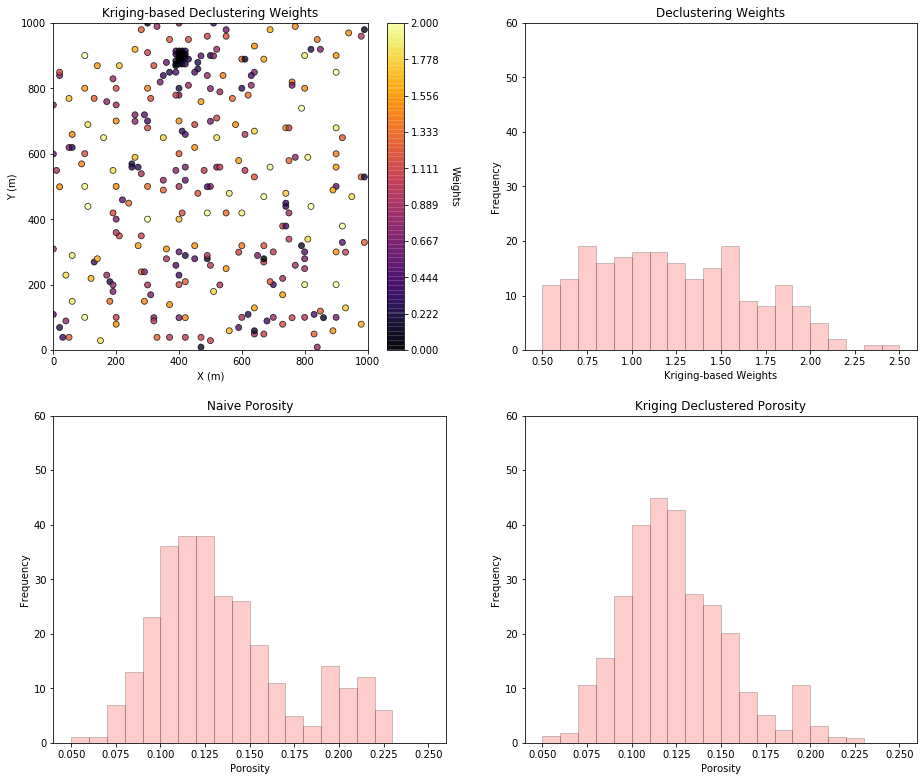

In [20]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts_kriging',xmin,xmax,ymin,ymax,0.0,2.0,'Kriging-based Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(222)
GSLIB.hist_st(df['Wts_kriging'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Kriging-based Weights",title="Declustering Weights")
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts_kriging'],xlabel="Porosity",title="Kriging Declustered Porosity")
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean[1] = np.average(df['Porosity'].values,weights=df['Wts_kriging'].values)

wts_mean[1] = np.average(df['Wts_kriging'].values)
wts_std[1] = np.std(df['Wts_kriging'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean[1],3))+'.')
cor = (por_mean-por_dmean[1])/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the declustering weights:')
print(stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

These declutering weights integrate:

* the spatial arrangement of the data

* the spatial continuity

* the study area of interest

### Polygonal Declustering

The polygonal declustering method is based on Voronio polygons of influence.

* weights are proportional to the area of the polygons standardized by the area of interest of the model

* the method is sensitive to the boundary of the area of interest

In [21]:
def declus_poly(
    df,
    xcol,
    ycol,
    vcol,
    tmin,
    tmax,
    nx,
    xmn,
    xsiz,
    ny,
    ymn,
    ysiz           
):
    """GSLIB's KB2D program (Deutsch and Journel, 1998) converted from the
    original Fortran to Python by Michael Pyrcz, the University of Texas at
    Austin (Jan, 2019).
    :param df: pandas DataFrame with the spatial data
    :param xcol: name of the x coordinate column
    :param ycol: name of the y coordinate column
    :param vcol: name of the property column
    :param tmin: property trimming limit
    :param tmax: property trimming limit
    :param nx: definition of the grid system (x axis)
    :param xmn: definition of the grid system (x axis)
    :param xsiz: definition of the grid system (x axis)
    :param ny: definition of the grid system (y axis)
    :param ymn: definition of the grid system (y axis)
    :param ysiz: definition of the grid system (y axis)
    :return:
    """

# Load the data
    df_extract = df.loc[(df[vcol] >= tmin) & (df[vcol] <= tmax)]    # trim values outside tmin and tmax
    nd = len(df_extract)
    x = df_extract[xcol].values
    y = df_extract[ycol].values
    vr = df_extract[vcol].values
    wts = np.zeros(len(df_extract))
    
# Make a KDTree for fast search of nearest neighbours   
    dp = list((y[i], x[i]) for i in range(0,nd))
    data_locs = np.column_stack((y,x))
    tree = sp.cKDTree(data_locs, leafsize=16, compact_nodes=True, copy_data=False, balanced_tree=True)
    
# Loop over the grid
    ndmax = 1                                          # find the nearest data to the location
    index = np.zeros((ny,nx))
    xmin = xmn - xsiz*0.5; ymin = ymn - ysiz*0.5
    xmax = xmin + nx*xsiz; ymax = ymin + ny*ysiz
    xloc = np.arange(xmin,xmax,xsiz); yloc = np.arange(ymin,ymax,ysiz)
    iy = 0
    for ry in yloc:
        ix = 0
        for rx in xloc:
            current_node = (ry,rx)
            dist, nums = tree.query(current_node,ndmax) # use kd tree for fast nearest data search
            index[iy,ix] = nums
            wts[int(nums)] = wts[int(nums)] + 1
            ix = ix + 1
        iy = iy + 1
        
    sum_wts = np.sum(wts)
    if sum_wts > 0.0:
        wts = wts / sum_wts * nd
        print('Standardized to sum of weights of ' + str(sum_wts))
        print('New sum of weights is ' + str(np.sum(wts)))
        
    return wts

# @jit(nopython=True)
# def poly_declus(nx,ny,dx,dy,listx,listy):
#     index = np.zeros((nx*ny,))
#     for i in range(nx*ny):
#         distance = 1e12
#         for j in range(len(listx)):
#             pp = np.sqrt((((i%nx-1)*dx+dx/2)-listx[j])**2+(((i//nx)*dy+dy/2)-listy[j])**2)
#             if pp <= distance:
#                 distance = pp
#                 index[i]=j
#     return index
# # ii=poly_declus(nx,ny,dx,dy,listx,listy)
# df['wt'] = np.zeros((len(listx),))
# for j in range(len(listx)):
#     df['wt'][j] = ii.tolist().count(j)/(nx*ny) #create a new column of weights in the dataframe


In [22]:
wts_poly = declus_poly(df,'X','Y','Porosity',tmin,tmax,nx,xmn,xsiz,ny,ymn,ysiz)
df['Wts_poly']=wts_poly

Standardized to sum of weights of 10000.0
New sum of weights is 289.0


In [23]:
df.head()

,X,Y,Facies,Porosity,Perm,Wts,Wts_kriging,Wts_poly
0,100,900,1,0.115359,5.736104,3.064286,2.057245,4.7685
1,100,800,1,0.136425,17.211462,1.076608,1.542516,1.3872
2,100,600,1,0.135810,43.724752,0.997239,1.170270,1.0982
3,100,500,0,0.094414,1.609942,1.165119,1.938405,1.5895
4,100,100,0,0.113049,10.886001,1.224164,1.965014,1.7051


Porosity naive mean is 0.135.
Porosity declustered mean is 0.122.
Correction of 0.0951.

Summary statistics of the polyognal declustering weights:
DescribeResult(nobs=289, minmax=(0.2819756671865989, 3.984325446814365), mean=0.9999999999999996, variance=0.40927076480664726, skewness=1.9395015754905447, kurtosis=4.287460624778004)


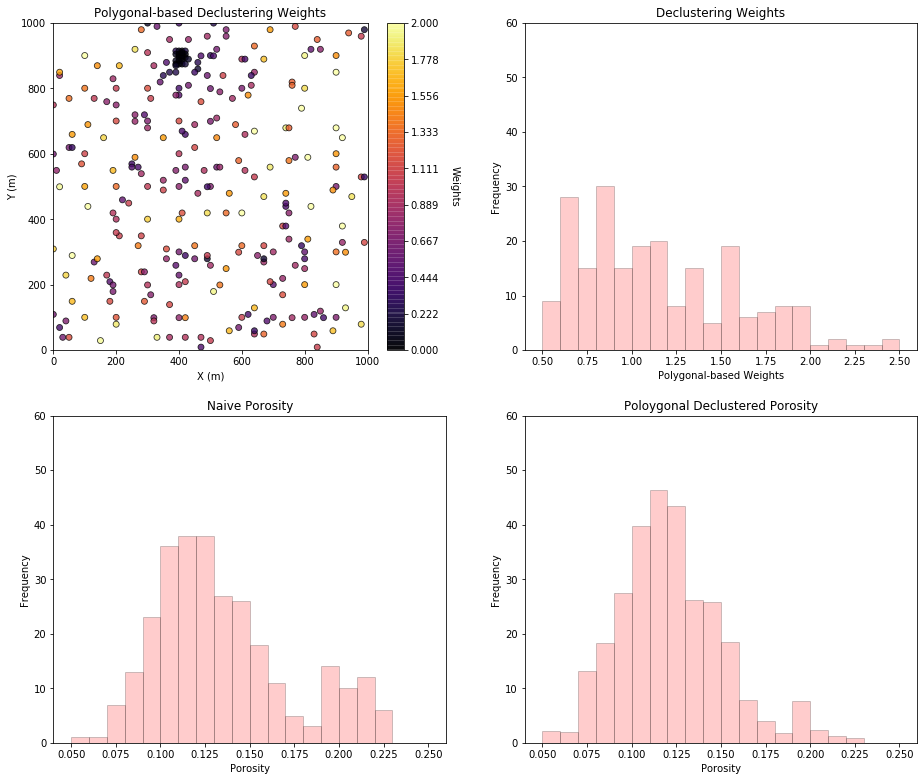

In [24]:
plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Wts_poly',xmin,xmax,ymin,ymax,0.0,2.0,'Polygonal-based Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(222)
GSLIB.hist_st(df['Wts_poly'],0.5,2.5,log=False,cumul=False,bins=20,weights=None,xlabel="Polygonal-based Weights",title="Declustering Weights")
plt.ylim(0.0,60)

plt.subplot(223)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=None,xlabel="Porosity",title="Naive Porosity")
plt.ylim(0.0,60)

plt.subplot(224)
GSLIB.hist_st(df['Porosity'],0.05,0.25,log=False,cumul=False,bins=20,weights=df['Wts_poly'],xlabel="Porosity",title="Poloygonal Declustered Porosity")
plt.ylim(0.0,60)

por_mean = np.average(df['Porosity'].values)
por_dmean[2] = np.average(df['Porosity'].values,weights=df['Wts_poly'].values)

wts_mean[2] = np.average(df['Wts_poly'].values)
wts_std[2] = np.std(df['Wts_poly'].values)

print('Porosity naive mean is ' + str(round(por_mean,3))+'.')
print('Porosity declustered mean is ' + str(round(por_dmean[2],3))+'.')
cor = (por_mean-por_dmean[2])/por_mean
print('Correction of ' + str(round(cor,4)) +'.')

print('\nSummary statistics of the polyognal declustering weights:')
print(stats.describe(wts))

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.5, wspace=0.2, hspace=0.2)
plt.show()

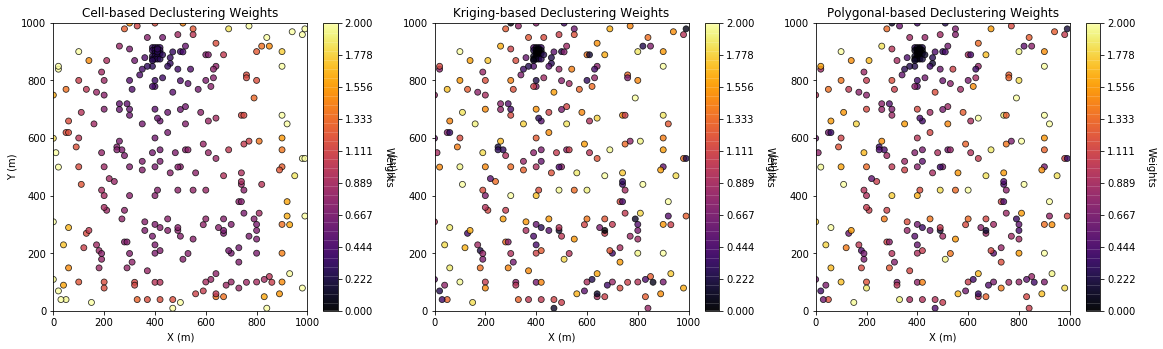

In [25]:
plt.subplot(131)
GSLIB.locmap_st(df,'X','Y','Wts',xmin,xmax,ymin,ymax,0.0,2.0,'Cell-based Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(132)
GSLIB.locmap_st(df,'X','Y','Wts_kriging',xmin,xmax,ymin,ymax,0.0,2.0,'Kriging-based Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplot(133)
GSLIB.locmap_st(df,'X','Y','Wts_poly',xmin,xmax,ymin,ymax,0.0,2.0,'Polygonal-based Declustering Weights','X (m)','Y (m)','Weights',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.5, top=1.0, wspace=0.2, hspace=0.2)
plt.show()

#### Interpretation of the Diagnostics

* **Use Declustering** - the difference in the declustering vs. naive feature means are significant, declustering should be applied.

* **No Boundary Issues** - the cell and polygonal declustered means are very similar indicating that the boundary of the area of interest is not significantly impacting the result

* **Spatial Continuity Should be Included** - kriging declustered mean is higher than both cell and polyonal declustering indicating that directionality and other variogram features may have an important impact.  It may not be approapriate to use cell nor polygonal declustering as they omit spatial continuity information.


#### Comments

This was a basic demonstration of declustering to correct for sampling bias. Much more could be done, I have other demonstrations on the basics of working with DataFrames, ndarrays and many other workflows availble at https://github.com/GeostatsGuy/PythonNumericalDemos and https://github.com/GeostatsGuy/GeostatsPy.

I have other demonstrations on the basics of working with DataFrames, ndarrays, univariate statistics, plotting data, declustering, data transformations, trend modeling and many other workflows available at [Python Demos](https://github.com/GeostatsGuy/PythonNumericalDemos) and a Python package for data analytics and geostatistics at [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy). 
  
I hope this was helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)